# The Quantum Phase Estimation Algorithm

In [1]:
import time
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Pauli, SparsePauliOp

import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import numpy as np
import math
plt.style.use('ibmq-dark')
%config InlineBackend.figure_format='retina'

### First, let's make the cells wider :) 

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Import the Sampler primitive

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

Have to first save Runtime account credentials if you have not done so already:

```python
QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
```

the `channel` keyword argument lets the Runtime know you are using the regular IBM Quantum access channel.  The other options is for IBM Cloud `channel='ibm_cloud'`.

In [4]:
service = QiskitRuntimeService(channel='ibm_quantum')

The service automatically allows for access to all backends that you can access:

In [5]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_armonk')>,
 <IBMBackend('ibmq_montreal')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibmq_brooklyn')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibm_wellington')>,
 <IBMBackend('ibm_ithaca')>,
 <IBMBackend('ibm_peekskill')>,
 <IBMBackend('ibmq_toronto')>,
 <IBMBackend('ibmq_bogota')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_washington')>,
 <IBMBackend('alt_montreal')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('simulator_qasm3')>,
 <IBMBackend('ibmq_santiago')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>]

In [6]:
backend_sim = service.backend('ibmq_qasm_simulator')

In [7]:
# Use eigenstate X

In [8]:
def make_qpe_circuit(eigenvalue, bits):

    def Unitary_eff(eigenvalue):

        Unitary = [-2*eigenvalue, -np.pi/2, np.pi/2]

        return Unitary
    
    def controlled_unitary(Unitary, control, target, circuit):
        circuit.p((Unitary[2]-Unitary[1])/2, target)
        circuit.cx(control, target)
        circuit.u(-Unitary[0]/2,0,-(Unitary[2]+Unitary[1])/2, target)
        circuit.cx(control, target)
        circuit.u(Unitary[0]/2,Unitary[1],0, target)
        return circuit
    
    def qft_dagger(qc, n):
        for j in range(n):
            for m in range(j):
                qc.cp(-math.pi/float(2**(j-m)), m, j)
            qc.h(j)

    # Create a Quantum Register - Q0: Ancilla; Q1: Register
    qr = QuantumRegister(bits+1, name='qn')
    # Create a Classical Register
    cr = ClassicalRegister(bits)
    # Create a Quantum Circuit
    qc = QuantumCircuit(qr, cr)

    qc.h(qr[bits])


    # Apply controlled-unitaries, conditional rotations, and measure in the X-basis
    for nind in range(bits):
        k = bits-nind

        #First, prepare ancilla in |+>

        qc.h(qr[nind])

        #Now, apply sequence of 2**(k-1) controlled-Unitary

        controlled_unitary(Unitary_eff(eigenvalue*(2**(k-1))), qr[nind], qr[bits], qc)

    qc.barrier()
    qft_dagger(qc, bits)

    qc.barrier()
    qc.measure(range(bits), range(bits))


    return qc

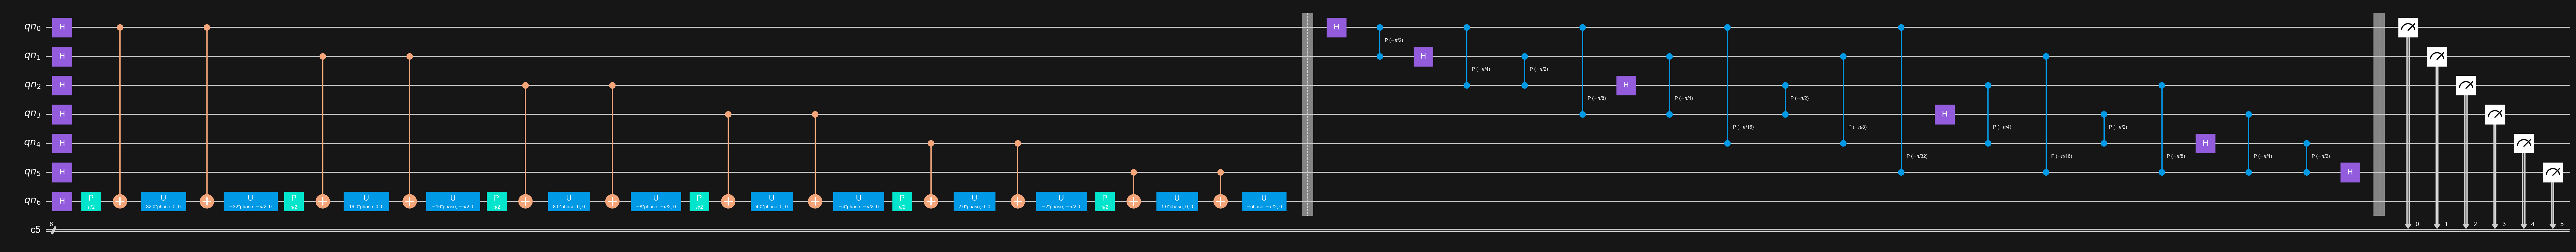

In [130]:
phase = Parameter('phase')

qpe_circuits = make_qpe_circuit(phase, 6)
qpe_circuits.draw('mpl',fold=-1)

In [40]:
number_of_phases = 80
phases = np.linspace(0, 4*np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [132]:
with Sampler(circuits=[qpe_circuits], service=service, options={ "backend": backend_sim }) as sampler:
    param_results = sampler(circuit_indices=[0]*len(phases), parameter_values=individual_phases)

In [12]:
def evaluate_wrap(phase, phi):
    # Choose whether to wrap or not. phase is the problem phase. phi is the computation output.
    if np.abs(wrapAngle(phi) - phase/(2*np.pi)) < np.abs(phi - phase/(2*(np.pi))):
        return wrapAngle(phi)
    else:
        return phi
    
def output_to_phi(bitstring):
    bin_exp = 0
    for ind, stringbit in enumerate(bitstring):
        bin_exp += int(stringbit)/2**(ind+1)
    return bin_exp

def wrapAngle(phase):
    # This function maps the interval \varphi \in [0,1] into [-0.5, 0.5] where the sub-inverval [0.5,1] moves into [-0.5,0] and the interval [0,0.5] remains untouched
    # Phases between pi and 2pi become negative
    phase_wrapped = ((phase*2*np.pi + np.pi) % (2 * np.pi) - np.pi)/(2*np.pi)
    return phase_wrapped

def most_likely_bitstring(dictionary):
    return max(dictionary, key=dictionary.get)

In [19]:
def most_likely_bits(dictionary, phi):

    # Return IPE result if one looks only at the most likely outcome and if one looks at the two most likely
    # outcomes
    val = list(dictionary.values())
    val.sort()
    counts_left = 0
    counts_right = 0
    most_likely_counts = val[-1]

    # First we compute the second most likely key without enforcing neighborhood

    if len(dictionary) > 1:

        second_most_likely_counts = val[-2]

    else:

        second_most_likely_counts = most_likely_counts

    for key, value in dictionary.items():

        if value == most_likely_counts:

            most_likely_key = key

        if value == second_most_likely_counts:

            if len(dictionary) > 1 and val[-2] == val[-1]:

                second_most_likely_key = [key for key, value in dictionary.items() if value == val[-2] and key != most_likely_key]
                second_most_likely_key = second_most_likely_key[0]
            else:
                second_most_likely_key = key


    neighbor_left = len(most_likely_key)*'1' if most_likely_key == len(most_likely_key)*'0' else format((int(most_likely_key,2)-1), '0%sb'%len(most_likely_key))
    neighbor_right = len(most_likely_key)*'0' if most_likely_key == len(most_likely_key)*'1' else format((int(most_likely_key,2)+1), '0%sb'%len(most_likely_key))

    if len(dictionary) > 1:

        # First check if neighbor keys exist

        if neighbor_left in dictionary.keys():

            counts_left = dictionary[neighbor_left]

        if neighbor_right in dictionary.keys():

            counts_right = dictionary[neighbor_right]

    else:

        second_most_likely_neighbor_key = most_likely_key
        second_most_likely_neighbor_counts = most_likely_counts

    if counts_left == 0 and counts_right == 0:

        second_most_likely_neighbor_key = most_likely_key
        second_most_likely_neighbor_counts = most_likely_counts

    else:

        if counts_left > counts_right:

            second_most_likely_neighbor_key = neighbor_left
            second_most_likely_neighbor_counts = counts_left

        else:

            second_most_likely_neighbor_key = neighbor_right
            second_most_likely_neighbor_counts = counts_right


    # Here we have a dictionary with the outcomes, the two most likely bitstrings and their counts
    # We want to return the most likely bitstring and an average of the counts of the two most
    # likely bitstrings

    most_likely_bit_phase = evaluate_wrap(2*np.pi*phi, output_to_phi(most_likely_key))
    second_most_likely_neighbor_bit_phase = evaluate_wrap(2*np.pi*phi,output_to_phi(second_most_likely_neighbor_key))
    second_most_likely_bit_phase = evaluate_wrap(2*np.pi*phi, output_to_phi(second_most_likely_key))


    # Now average both second most likely keys
#     numer = (most_likely_counts*most_likely_bit_phase + second_most_likely_counts*second_most_likely_bit_phase)
#     denom = (most_likely_counts+second_most_likely_counts)
#     two_most_likely_bits_phase = numer/denom

    numer = (most_likely_counts*most_likely_bit_phase + second_most_likely_neighbor_counts*second_most_likely_neighbor_bit_phase)
    denom = (most_likely_counts+second_most_likely_neighbor_counts)
    two_most_likely_neighbor_bits_phase = numer/denom

    return two_most_likely_neighbor_bits_phase

In [134]:
qpe_solution = []
for idx, results in enumerate(param_results.quasi_dists):
    solution = most_likely_bitstring(results)
    phase = evaluate_wrap(phases[idx], output_to_phi(solution))
#     phase = output_to_phi(solution)
    qpe_solution.append(2*np.pi*phase)

In [42]:
qpe_solution = []
for idx, results in enumerate(param_results.quasi_dists):
    solution = most_likely_bits(results, phases[idx]/(2*np.pi))
    qpe_solution.append(2*np.pi*solution)

In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'figure.figsize': (10, 6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

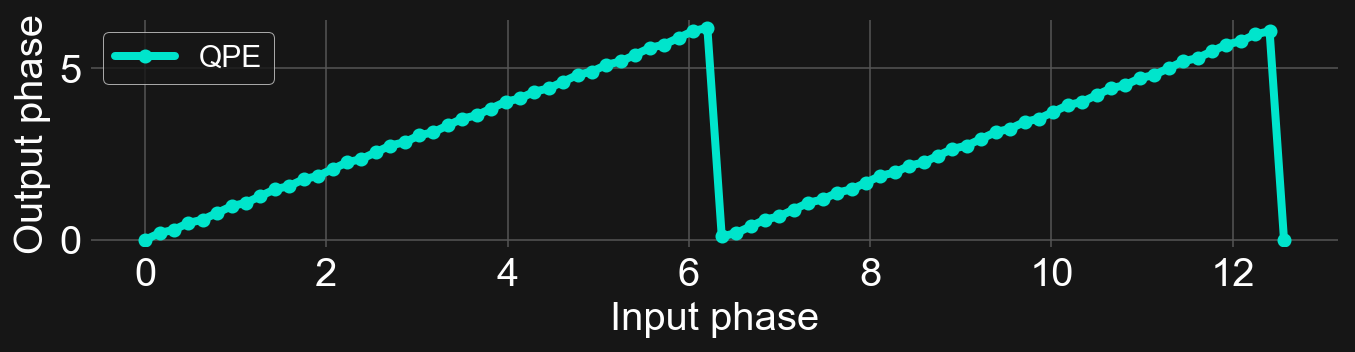

In [135]:
fig = plt.figure(figsize=(10, 2))

# ax1 = fig.add_axes([0, 0, 1, 1])

plt.plot(phases, qpe_solution, 'o-', label='QPE')
# plt.plot(phases, chsh2_sim, 'o-', label='CHSH2 Noiseless')
# plt.plot(phases, chsh1_exp, 'o-', label='CHSH1 Kolkata')
# plt.plot(phases, chsh2_exp, 'o-', label='CHSH2 Kolkata')
# plt.axhline(y=2, color='r', linestyle='-')
# plt.axhline(y=-2, color='r', linestyle='-')
# plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
# plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Input phase')
plt.ylabel('Output phase')
plt.legend()